Let's discuss a simplified version of the QARMAv2 cipher, specifically the QARMAv2-64-128 version.

## Round functions

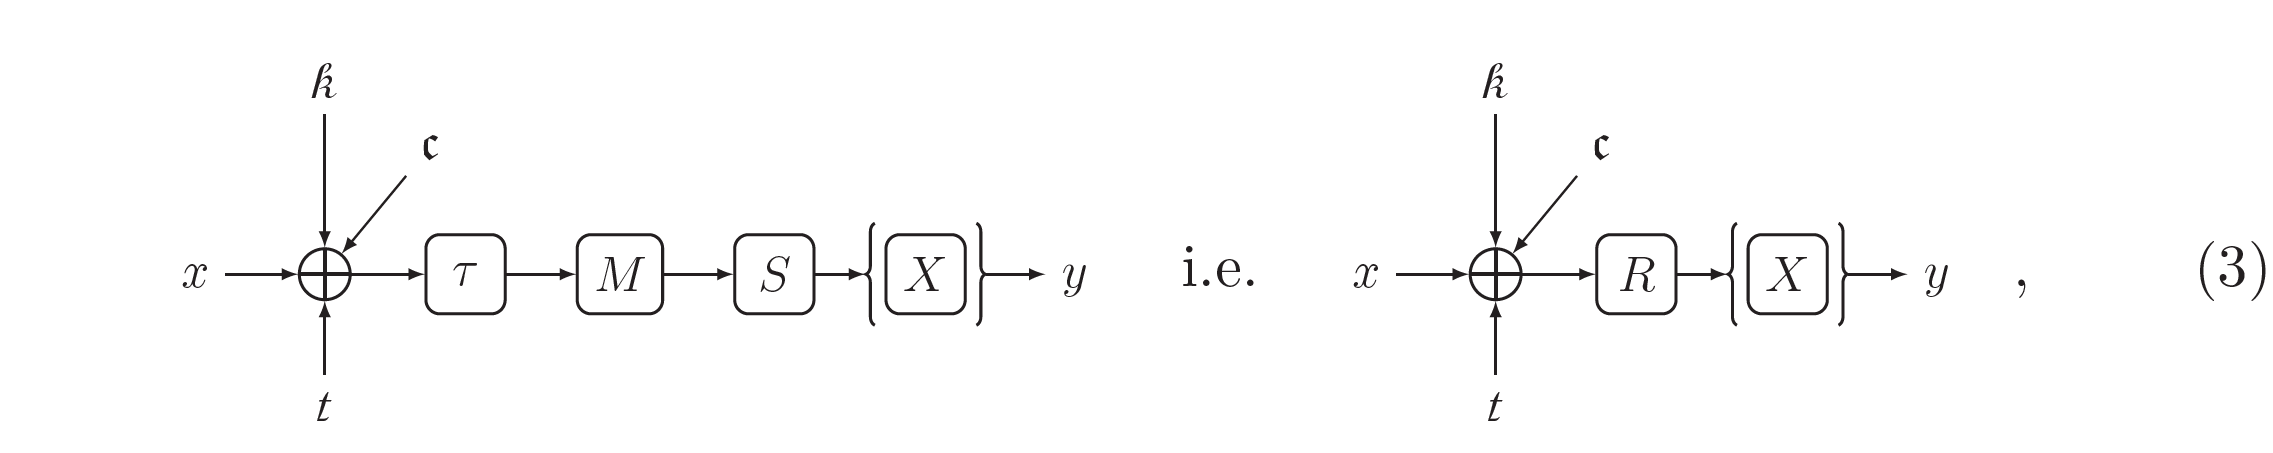

The round function is consist of tau_permutation, mix_columns, and S-box. 

In [1]:
# permutation functions
tau = [0, 11, 6, 13, 10, 1, 12, 7, 5, 14, 3, 8, 15, 4, 9, 2]
tau_inverse = [tau.index(i) for i in range(len(tau))]

def permutation(state: list, p: list) -> list:
    return [state[p[i]] for i in range(len(state))]


state = [i for i in range(16)]
state = permutation(state, tau)
if state == tau:
    print("permutation function is working")
if permutation(state, tau_inverse) == [i for i in range(16)]:
    print("inverse permutation function is working")

permutation function is working
inverse permutation function is working


$\rho((x_3, x_2, x_1, x_0)) = (x_2, x_1, x_0, x_3)$ 

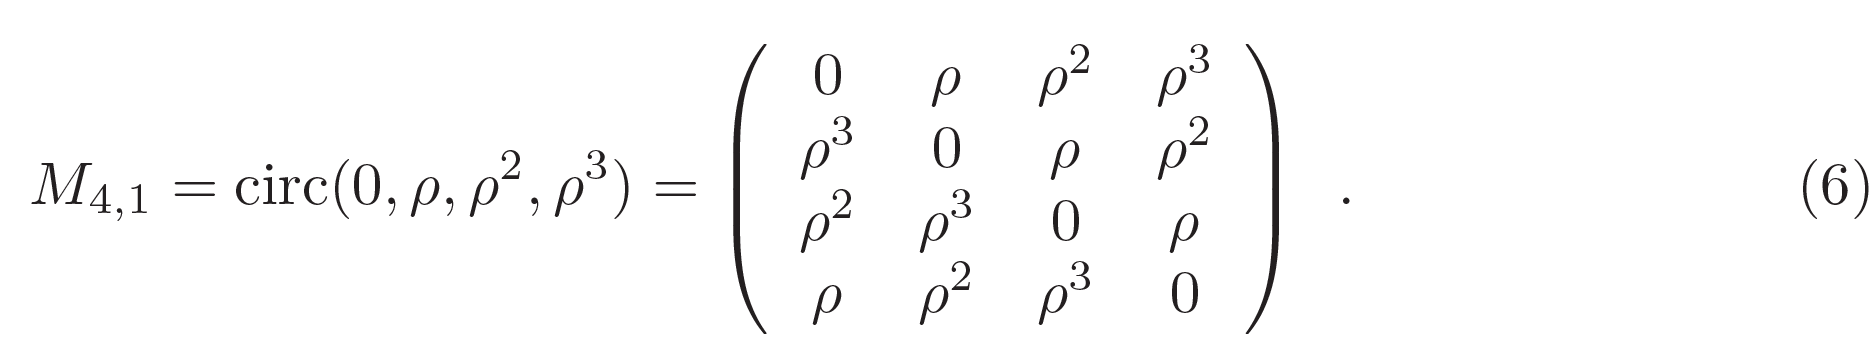

In [2]:
# the rho is represent by rotate_left(value,1)
def rotate_left(value: int, shift: int) -> int:
    return ((value << shift) | (value >> (4 - shift))) & 0xF


value = 0b0010
shift_amount = 4
bin(rotate_left(value, shift_amount))

'0b10'

In [13]:
# perfectly working
# the mix_column is involution, amazing thing !!!
def mix_column(state: list) -> list:
    result = state[:]
    for i in range(4):
        for j in range(4):
            index = i + j * 4
            result[index] = (
                rotate_left(state[(index + 4) % 16], 1)
                ^ rotate_left(state[(index + 8) % 16], 2)
                ^ rotate_left(state[(index + 12) % 16], 3)
            )
    return result


# state = [8] * 4 + [4] * 4 + [2] * 4 + [1] * 4
state = [8, 4, 2, 1] * 4
print(mix_column(state))
print(mix_column(mix_column(state)))

[7, 11, 13, 14, 7, 11, 13, 14, 7, 11, 13, 14, 7, 11, 13, 14]
[8, 4, 2, 1, 8, 4, 2, 1, 8, 4, 2, 1, 8, 4, 2, 1]


In [2]:
S = [0x4, 0x7, 0x9, 0xB, 0xC, 0x6, 0xE, 0xF, 0x0, 0x5, 0x1, 0xD, 0x8, 0x3, 0x2, 0xA]
S_inverse = [S.index(i) for i in range(len(S))]


def s_box(state: list, S: list) -> list:
    return [S[state[i]] for i in range(len(state))]


state = [i for i in range(16)]
state = s_box(state, S)
if state == S:
    print("s_box function is working")
if s_box(state, S_inverse) == [i for i in range(16)]:
    print("inverse s_box function is working")

s_box function is working
inverse s_box function is working


## The Round Keys

$o(w):=(w>>>1)+(w>>(b-1))(8)$

$o^{-1}(w) := (w<<<1)+ (w>>(b-3)\&2)$

$K = K_0||K_1$

$\iota_e:(K_0,K_1)\mapsto(L_0,L_1):=(o(K_0)+\alpha,o^{-1}(K_1)+\beta)$

$W_0 = o^2(K_0) \, W_1 = o^{−2}(K_1)$

In [12]:
def o_func(w: int, b: int) -> int:
    t1 = (w >> 1) | (w << (b - 1)) & ((1 << b) - 1)
    t2 = w >> (b - 1)
    return t1 ^ t2

def o_func_inverse(w: int, b: int) -> int:
    t1 = (w << 1) & ((1 << b) - 1) | (w >> (b - 1)) 
    t2 = w >> (b-3) & (2) 
    return t1 ^ t2

w = 0x8000000000000000
b = 64
w = o_func(w, b)
print(hex(w))
if o_func_inverse(w, b) == 0x8000000000000000:
    print("o_func and o_func_inverse are working")

0x4000000000000001
o_func and o_func_inverse are working
